In [1]:
# This notebook was built on Google colab and uses data form google drive
# Also the notebook was built using multiple sessions saving the intermediate outputs to avoid overshooting the RAM

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx
import math
import pickle

### Load data

In [4]:
parent_folder = "/content/drive/MyDrive/AAIC/Projects/Facebook Friend Recommendation /data"
train_graph = nx.read_edgelist(parent_folder + '/train_pos.csv', delimiter=',', create_using=nx.DiGraph(), nodetype=int)
print(nx.info(train_graph))

DiGraph with 1780722 nodes and 7550015 edges


In [5]:
df_final_train = pd.read_hdf(parent_folder + '/Features/sample_with_features_1.h5', 'train_df',mode='r')
df_final_test = pd.read_hdf(parent_folder + '/Features/sample_with_features_1.h5', 'test_df',mode='r')

In [9]:
df_final_train.shape

(100001, 9)

In [13]:
df_final_train.head()

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_following_s,num_following_d,inter_followers,inter_following
0,273084,1505602,1,11,15,6,8,0,0
1,1593259,673140,1,8,3,19,8,0,0
2,355711,1610892,1,9,18,2,1,1,0
3,80115,1473881,1,3,55,83,99,1,12
4,336918,226190,1,14,16,7,5,0,0


In [14]:
df_final_test.shape

(50001, 9)

In [15]:
df_final_test.head()

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_following_s,num_following_d,inter_followers,inter_following
0,848424,784690,1,6,6,14,9,1,0
1,1190268,217891,1,34,35,17,21,3,5
2,1095925,325140,1,0,2,12,13,0,1
3,571364,684722,1,1,6,7,2,0,0
4,1851322,840484,1,5,7,7,13,2,5


## Features

### Is user following back ?

In [16]:
def does_follow_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

### Shortest path
- If there exists a direct link, we consider the shortest path except direct link
- If no path found, we assign -1

In [24]:
def get_shortest_path_length(a, b):
    l = -1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            l = nx.shortest_path_length(G=train_graph, source=a, target=b)
            train_graph.add_edge(a,b)
        else :
            l = nx.shortest_path_length(G=train_graph, source=a, target=b)
        return l
    except:
        return -1

In [25]:
get_shortest_path_length(77697, 826021)

10

### Checking for same community
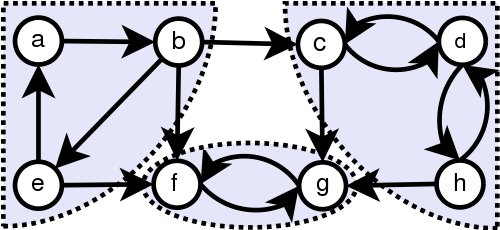
https://commons.wikimedia.org/wiki/File:Scc.png#%2Fmedia%2FFile%3AScc.png
<br>
References : https://www.quora.com/What-are-strongly-and-weakly-connected-components

Here a,b,e belong to same community
<br>
Intution :  if there is the path other then direct path then they both belong to same WCC community else they don't belong to same WCC community

In [48]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))

def belongs_to_same_wcc(a,b):
    community = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    community= i
                    break
            if (b in community):
                train_graph.remove_edge(a,b)
                if get_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    community= i
                    break
            if(b in community):
                return 1
            else:
                return 0

In [53]:
wcc[10]

{265641, 1007826, 1757704}

In [54]:
belongs_to_same_wcc(265641, 1757704)

1

### Adamic - Adar index

$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

where N(u) is the set of nodes adjacent to u. 
<br>
The definition is based on the concept that common elements with very large neighbourhoods are less significant when predicting a connection between two nodes compared with elements shared between a small number of nodes.
<br>
Reference : https://en.wikipedia.org/wiki/Adamic%E2%80%93Adar_index

In [68]:
def get_adar_index(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [71]:
get_adar_index(1,189226)

0

## Compute features

In [72]:
# does followback or not on train
df_final_train['does_follow_back'] = df_final_train.apply(lambda row: does_follow_back(row['source_node'],row['destination_node']),axis=1)

# does followback or not on test
df_final_test['does_follow_back'] = df_final_test.apply(lambda row: does_follow_back(row['source_node'],row['destination_node']),axis=1)

In [73]:
# shortest path on train 
df_final_train['shortest_path'] = df_final_train.apply(lambda row: get_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

# shortest path on test
df_final_test['shortest_path'] = df_final_test.apply(lambda row: get_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

In [74]:
# same component of wcc or not on train
df_final_train['same_wcc_com'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

# same component of wcc or not on train
df_final_test['same_wcc_com'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

In [75]:
# adar index on train
df_final_train['adar_index'] = df_final_train.apply(lambda row: get_adar_index(row['source_node'],row['destination_node']),axis=1)

# adar index on test
df_final_test['adar_index'] = df_final_test.apply(lambda row: get_adar_index(row['source_node'],row['destination_node']),axis=1)

In [78]:
df_final_train.tail(2)

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_following_s,num_following_d,inter_followers,inter_following,does_follow_back,shortest_path,same_wcc_com,adar_index
99999,1091070,224583,0,3,7,2,2,0,0,0,11,1,0.0
100000,1073208,805728,0,0,0,1,1,0,0,0,-1,0,0.0


In [77]:
df_final_test.head(2)

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_following_s,num_following_d,inter_followers,inter_following,does_follow_back,shortest_path,same_wcc_com,adar_index
0,848424,784690,1,6,6,14,9,1,0,1,2,1,0.000000
1,1190268,217891,1,34,35,17,21,3,5,1,2,1,3.450508


### Save results

In [79]:
hdf = pd.HDFStore(parent_folder + '/Features/sample_with_features_2.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()